In [1]:
import pandas as pd
import math
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import datetime as dt
import networkx as nx
from matplotlib import pylab
import sys
import unittest
import time
import datetime
import seaborn as sns
from matplotlib.widgets import Button

In [2]:
sys.path.append('../code')

In [9]:
import generateGraphs as gg
import fixdata as fd

In [4]:
df = pd.read_csv("../data/CometLandingFixed.csv",
                 dtype={"id_str": str, "in_reply_to_user_id_str": str, "from_user_id_str": str,
                        "in_reply_to_status_id_str": str, "user_followers_count": "Int64",
                        "user_friends_count": "Int64", "geo_coordinates": str}, parse_dates=['created_at']
                 )


In [5]:
# to be removed if fixdata.py works fine
fd.create_retweet_columns(df)

In [6]:
df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,...,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str,specific_applications,applications,retweet_user_id_str,retweet_user_screen_name,retweet_user_name
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,...,http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56...",Twitter Web Client,Twitter,30264992,VersaTechnology,Versa Technology
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,...,http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Websites,Twitter,NaN,NaN,NaN
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,...,http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPad,Twitter,206717989,EUCouncil,EU Council
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,...,http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter,206717989,EUCouncil,EU Council
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,...,http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices...",Twitter for Android,Twitter,17680518,shaunmajumder,Shaun Majumder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,...,http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",TweetCaster for Android,TweetCaster for Android,NaN,NaN,NaN
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,...,http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",Twitter for Android Tablets,Twitter,1041442471,ObservingSpace,Observing Space
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,...,http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter Web Client,Twitter,205195655,maxplanckpress,Max Planck Society
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,...,http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter,NaN,NaN,NaN


Data Cleaning: <br>
The duplicated records are first removed.  Then, records without any of the following essetial fields (ie. value = Nan) are also removed: id_str (Tweet ID), from_user_id_str (User ID), text (Tweet text), entities_str (information including hashtags used, users mentioned and used URL).  These fields are considered essential for analysing the dataset that we decide to remove records without any of these fields as they will not be usable for analysis.  The data are also filtered so that only tweets between 2014-11-12 and 2014-12-05 inclusively remain.  Additional filtering is also done to make sure all tweets in the dataset contain the hashtag "CometLanding" of any case as this should be the criteria of the tweets being in this dataset.

New Fields: <br>
New columns "specific_applications" and "applications" are added to store the application used for sending the tweet. "specific_applications" treated the same application for different devices as distinct applications (eg. Twitter for iPhone is different from Twitter for Android) while "applications" generalize them as the same application (eg. Twitter for iPhone and Twitter for Android are stored as Twitter).  There are also new columns added for information related to the user being retweeted: "retweet_user_id_str" (Retweeted User ID), "retweet_user_screen_name" (Retweeted User screen name), "retweet_user_name" (Retweeted User username).

Removed Field: <br>
The field "time" is removed as it seems to duplicate with "created_at" but with less information.

Refine ID: <br>
"id_str" is refined with the "status_url".  Specifically, its value is replaced with the last 18 characters of "status_url".  This decision starts from the observation that the original values of "id_str" of 18 digits are not unique ie. there are some tweets that share the same ID, which should not be the case.  Then, it is observed that the URL in "status_url" always end with also 18 digits, and the first 15 digits are always the same as that of "id_str".  In addition to the fact the the last 3 digits of "id_str" are always zeroed, it is concluded that the original value of "id_str" are merely the 15 digits prefix of the actual Tweet ID with the last 3 zeroed, and that the one in "status_url" is the actual, full Tweet ID.  This conclusion is also supported by the fact that all values in "status_url" are unique.  Thus, the substitution is made for tweets with non-empty "status_url" field, or else "id_str" field remains the same.

In [536]:
type(df["created_at"])


pandas.core.series.Series

In [13]:
total_replies = df[pd.notna(df["in_reply_to_user_id_str"])]  # replies
total_retweets = df[pd.notna(df['retweet_user_id_str'])] # retweets
retweet_reply = df.dropna(subset=['in_reply_to_user_id_str', 'retweet_user_id_str']) # replies that are also retweets
tweet_only = df[pd.isna(df["in_reply_to_user_id_str"]) & pd.isna(df['retweet_user_id_str'])]
reply_only = total_replies[pd.isna(total_replies['retweet_user_id_str'])]
retweet_only = total_retweets[pd.isna(total_retweets["in_reply_to_user_id_str"])]

In [14]:
print("Total number of tweets: " + str(len(df)))
print("Total number of replies: " + str(len(total_replies)))
print("Total number of retweets: " + str(len(total_retweets)))
print("Number of replies that are also retweets: " + str(len(retweet_reply)))
print("Number of replies that are not retweets: " + str(len(reply_only)))
print("Number of retweets that are not replies: " + str(len(retweet_only)))
print("Number of tweets that are neither reply nor retweet: " + str(len(tweet_only)))

Total number of tweets: 77307
Total number of replies: 1724
Total number of retweets: 59959
Number of replies that are also retweets: 30
Number of replies that are not retweets: 1694
Number of retweets that are not replies: 59929
Number of tweets that are neither reply nor retweet: 15654


In [15]:
from_users = set(df["from_user_id_str"])

In [17]:
print("Total no. of unique users: " + str(len(from_users)))

Total no. of unique users: 50216


In [23]:
print("Average retweets by a user: " + str(len(retweet_only) / len(from_users))) # excluding retweets that are replies
print("Average tweets by a user: " + str(len(tweet_only) / len(from_users))) # excluding retweets and replies
print("Average replies by a user: " + str(len(total_replies) / len(from_users)))

Average retweets by a user: 1.193424406563645
Average tweets by a user: 0.3117333120917636
Average replies by a user: 0.034331687111677556


In [24]:
# users receiving a reply
replied_users = set(total_replies["in_reply_to_user_id_str"]) 
# users that either have sent/replied/retweeted a tweet or received a reply
all_users_with_reply = from_users.union(replied_users) 
# users that both have sent/replied/retweeted a tweet and received a reply
from_users_with_reply = from_users.intersection(replied_users)
# get replies that are to users that have also tweeted/replied/retweeted
replies_to_from_users = total_replies[total_replies["in_reply_to_user_id_str"].isin(from_users)]

In [37]:
print("Average number of reply received by each user: " + str(len(total_replies) / len(all_users_with_reply)))
print("Average number of reply received by each replied user: " + str(len(total_replies) / len(replied_users)))
print("Average number of reply received by each user that has also tweeted/replied/retweeted: "
     + str(len(replies_to_from_users)/len(set(df["from_user_id_str"]))))
print("Number of users received reply: " + str(len(replied_users)))
print("Number of users who have tweeted/replied/retweeted and received a reply: " + str(len(from_users_with_reply)))
print("Number of users either send/reply/retweet or received a reply: " + str(len(all_users_with_reply)))
print("No. of replies where replied user has tweeted/retweeted/replied: " + str(len(replies_to_from_users)))

Average number of reply received by each user: 0.03408731414109459
Average number of reply received by each replied user: 2.1576971214017524
Average number of reply received by each user that has also tweeted/replied/retweeted: 0.026186872709893262
Number of users received reply: 799
Number of users who have tweeted/replied/retweeted and received a reply: 439
Number of users either send/reply/retweet or received a reply: 50576
No. of replies where replied user has tweeted/retweeted/replied: 1315


In [27]:
# users being retweeted
retweeted_user = set(total_retweets["retweet_user_id_str"])
# users that are either retweeted or have tweeted/retweeted/replied
all_users_with_rt = from_users.union(retweeted_user)
# users that both have sent/replied/retweeted a tweet and are retweeted
from_users_retweeted = from_users.intersection(retweeted_user)
# retweets where retweeted users have sent/replied/retweeted
retweets_from_users = total_retweets[total_retweets['retweet_user_id_str'].isin(from_users)]
# https://www.datacamp.com/community/tutorials/python-dictionary-comprehension
# users that are retweeted and have tweeted/retweeted/replied with no. being retweeted
# retweeted_from_user = {user: rt for (user, rt) in retweeted_user.items() if user in set(df["from_user_id_str"])}

In [36]:
print("Average no. each retweeted user being retweeted: " + str(len(total_retweets) / len(retweeted_user)))
print("Average no. each user being retweeted: " + str(len(total_retweets) / len(all_users_with_rt)))
print("Average no. each user that has tweeted/retweeted/replied being retweeted: " + 
     str(len(retweets_from_users) / len(from_users)))
print("Number of users retweeted: " + str(len(retweeted_user)))
print("Number of users that are tweeted and has tweeted/retweeted/replied: " + str(len(from_users_retweeted)))
print("Number of users that are either tweeted or have tweeted/retweeted/replied: " + str(len(all_users_with_rt)))
print("No. of retweets where retweeted user has tweeted/retweeted/replied: " + str(len(retweets_from_users)))

Average no. each retweeted user being retweeted: 12.449958471760798
Average no. each user being retweeted: 1.149983697424193
Average no. each user that has tweeted/retweeted/replied being retweeted: 1.002290106738888
Number of users retweeted: 4816
Number of users that are tweeted and has tweeted/retweeted/replied: 2893
Number of users that are either tweeted or have tweeted/retweeted/replied: 52139
No. of retweets where retweeted user has tweeted/retweeted/replied: 50331


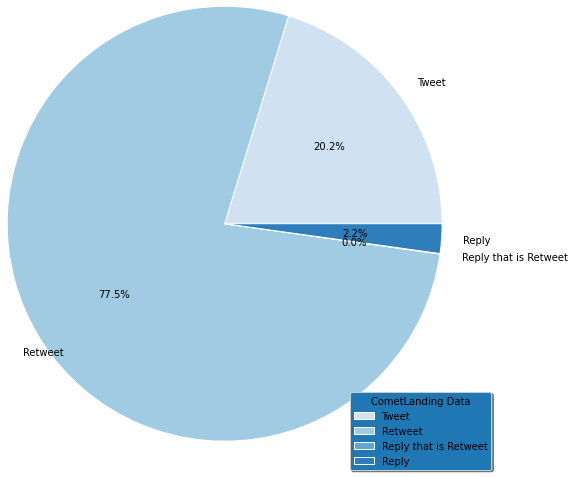

<Figure size 360x360 with 0 Axes>

In [7]:
gg.createTweetsTypeChart(df)
plt.show()
plt.clf()

As shown by the pie chart and the calculations above, most of the tweets in the dataset are retweet, followed by tweets that are neither reply nor retweet, and then replies.

In [562]:
def getNoOfUniqueUsers(df):
    average_different_users_tweet = df.groupby(
    ["from_user_id_str"]).agg(["count"])["from_user"]
    #average_different_users_tweet.mean()
    average_different_users_tweet.sort_values(by="count", ascending=False)
    man = average_different_users_tweet["count"].tolist()
    return len(man)


In [563]:
uniqueUsers = getNoOfUniqueUsers(df)


In [59]:
def readCSV():
       df = pd.read_csv("../data/CometLandingFixed.csv",
                     dtype={"id_str": str, "in_reply_to_user_id_str": str, "from_user_id_str": str,
                            "in_reply_to_status_id_str": str, "user_followers_count": "Int64",
                            "user_friends_count": "Int64", "geo_coordinates": str}, parse_dates=['created_at']
                 )
       return df

In [569]:
class Tests(unittest.TestCase):
   # Test on if filtering of dates is functioning properly.
   def test_one(self):
      df = readCSV()
      start_date = time.mktime(datetime.datetime.strptime('2014/11/12', "%Y/%m/%d").timetuple())
      end_date = time.mktime(datetime.datetime.strptime('2014/12/06', "%Y/%m/%d").timetuple())

      test_date_after_out = time.mktime(datetime.datetime.strptime('2014/12/07', "%Y/%m/%d").timetuple())
      test_date_before_out= time.mktime(datetime.datetime.strptime('2014/11/11', "%Y/%m/%d").timetuple())

      dfTest = fd.filterOutDates(df)
      for date in dfTest['created_at']:
          self.assertEqual(True, (date.timestamp() >= start_date))
          self.assertEqual(True, (date.timestamp() < end_date))

      self.assertEqual(False, (test_date_before_out >= start_date))
      self.assertEqual(True, (test_date_before_out < end_date))

      self.assertEqual(True, (test_date_after_out >= start_date))
      self.assertEqual(False, (test_date_after_out < end_date))

   pass
      
   # Test on if filtering of duplicates and null records is functioning properly.
   def test_two(self):
      df = readCSV()
      noOfRecordsBefore = len(df)
      
      dfTest = fd.removeDuplicatesNullRecords(df)
      noOfRecordsAfter = len(dfTest)
      self.assertEqual(noOfRecordsBefore, noOfRecordsAfter) # Nothing removed

      df.iloc[noOfRecordsBefore - 1] = df.iloc[1]
      #df.iloc[noOfRecordsBefore - 2] = NULL
      noOfRecordsBefore = len(df)
      dfTest = fd.removeDuplicatesNullRecords(df)
      noOfRecordsAfter = len(dfTest)

      self.assertEqual(noOfRecordsBefore - 1, noOfRecordsAfter) # One duplicate record removed

   pass

   # Test on if only replies can be found.
   def test_three(self):
      df = readCSV()
      replies = getAllReplies(df)

      # Checks they are all replies.
      for i in replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))

      tweets = getAllTweets(df)
      df.iloc[len(df) - 1] = tweets.iloc[1]

      # Checks that new tweet for example is not accepted.
      self.assertEqual(False, pd.notna(df['in_reply_to_user_id_str'][len(df) - 1]))
   pass

   # Test on if all retweets can be found.
   def test_four(self):
      df = readCSV()
      retweets = getAllRetweets(df)

      # Checks they are all retweets.
      for i in retweets['text']:
         self.assertEqual(True, i.startswith("RT @"))

      tweets = getAllTweets(df)
      df.iloc[len(df) - 1] = tweets.iloc[1]

      # Checks that new tweet for example is not accepted.
      self.assertEqual(False, df['text'][len(df) - 1].startswith("RT @"))
   pass

   # Test on if all tweets can be found.
   def test_five(self):
      df = readCSV()
      tweets = getAllTweets(df)
      for i in tweets['text']:
         self.assertEqual(False, i.startswith("RT @"))

      retweets = getAllRetweets(df)
      df.iloc[len(df) - 1] = retweets.iloc[1]

      # Checks that new tweet for example is not accepted.
      self.assertEqual(True, df['text'][len(df) - 1].startswith("RT @"))
   pass

   # Test on if only retweet replies can be found.
   def test_six(self):
      df = readCSV()
      retweet_replies = getAllRetweetReplies(getAllReplies(df))
      for i in retweet_replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))
      for i in retweet_replies['text']:
         self.assertEqual(True, i.startswith("RT @"))

      tweets = getAllTweets(df)
      df.iloc[len(df) - 1] = tweets.iloc[1]

      # Checks that new tweet for example is not accepted.
      self.assertEqual(False, df['text'][len(df) - 1].startswith("RT @"))
      self.assertEqual(False, pd.notna(df['in_reply_to_user_id_str'][len(df) - 1]))
   pass

   # Test on if only tweet replies can be found.
   def test_seven(self):
      df = readCSV()
      tweet_replies = getAllTweetReplies(getAllReplies(df))
      for i in tweet_replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))
      for i in tweet_replies['text']:
         self.assertEqual(False, i.startswith("RT @"))

      retweets = getAllRetweets(df)
      df.iloc[len(df) - 1] = retweets.iloc[1]

      # Checks that new retweet for example is not accepted.
      self.assertEqual(True, df['text'][len(df) - 1].startswith("RT @"))
      self.assertEqual(False, pd.notna(df['in_reply_to_user_id_str'][len(df) - 1]))
   pass

   # Tests that all replies are kept when they are split.
   def test_eight(self):
      df = readCSV()
      replies = getAllReplies(df)
      tweet_replies = getAllTweetReplies(replies)
      retweet_replies = getAllRetweetReplies(replies)
      self.assertEqual(len(replies), len(tweet_replies) + len(retweet_replies))
   pass

   # Tests that unique users amount is found.
   def test_nine(self):
      df = readCSV()
      df.iloc[1] = df.iloc[5]
      df.iloc[2] = df.iloc[5]
      df.iloc[3] = df.iloc[5]
      df.iloc[4] = df.iloc[5]
      uniqueUsers = getNoOfUniqueUsers(df)
      uniqueUsersTest = len(df["from_user_id_str"].unique())
      self.assertEqual(uniqueUsers, uniqueUsersTest)
   pass

   # Tests that unique hashtags are found.
   def test_ten(self):
      df = readCSV()
      allHashtags = getListOfAllHashTags()
      unique = getListOfUniqueHashtags(allHashtags.append('67P'))
      newunique = pd.Series(allHashtags)
      unique2 = newunique.unique()

      self.assertEqual(len(unique) < len(allHashtags), True)
      for i in range(len(unique)):
         self.assertEqual(unique[i], unique2[i])
      
   # Tests that top 25 hashtags are the same found in functions.
   def test_eleven(self):
      df = readCSV()
      allHashtags = getListOfAllHashTags()
      unique = getListOfUniqueHashtags(allHashtags)
      newdf = createDataFrameOfHashtagsAndFills(unique, allHashtags)
      newdf2 = newdf.reset_index()
      for i in range(25):
         self.assertEqual(newdf2['Frequency'][i], allHashtags.count(newdf2['Hashtags'][i]))
   pass


In [570]:
def suite():
 loader = unittest.TestLoader()
 testsuite = loader.loadTestsFromTestCase(Tests)
 return testsuite

In [571]:
def test():
 testsuite = suite()
 runner = unittest.TextTestRunner(sys.stdout, verbosity=2)
 result = runner.run(testsuite)

In [572]:
test()

test_eight (__main__.Tests) ... ok
test_eleven (__main__.Tests) ... 

C:\Users\thoma\AppData\Local\Temp/ipykernel_9220/3105913847.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency'][index] += 1


ok
test_five (__main__.Tests) ... ok
test_four (__main__.Tests) ... ok
test_nine (__main__.Tests) ... ok
test_one (__main__.Tests) ... ok
test_seven (__main__.Tests) ... ok
test_six (__main__.Tests) ... ok
test_ten (__main__.Tests) ... ok
test_three (__main__.Tests) ... 

C:\Users\thoma\AppData\Local\Temp/ipykernel_9220/3105913847.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hashtagsUnique = pd.Series(hashtagsFull)


ok
test_two (__main__.Tests) ... ok

----------------------------------------------------------------------
Ran 11 tests in 71.726s

OK


In [573]:


# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
#Network X

replies_network = nx.Graph()
seenNodes_replies = set()

for index, row in total_replies_df.iterrows():
    node_1 = row['in_reply_to_screen_name']
    if node_1 not in seenNodes_replies and node_1 is not None:
        replies_network.add_node(node_1)
        seenNodes_replies.add(node_1)
        
    node_2 = row['from_user']
    if node_2 not in seenNodes_replies and node_2 is not None :
        replies_network.add_node(node_2)
        seenNodes_replies.add(node_2)
        
    replies_network.add_edge(node_1,node_2)
  
    
    print(row['in_reply_to_screen_name'], row['from_user'])



NASA einfachbloggen
nathanbroon gwittrapp
ESA_Rosetta acolliver615
ESA_Rosetta WillemelliW
RT_com Chapuler38
NASA_Orion TonyPethtel
ReginePetersen mazmanian
ScienceNews IsidoraBojovicc
treyhughett1 cunningham_dc
Philae_Ptolemy masanorimusic
rtistforhire rtistforhire
ESA_Rosetta mixelaneo
carolynporco LaTambourine
teobesta teobesta
ESA_Rosetta masanorimusic
GummyTraveler GummyTraveler
ESA_Rosetta einfachbloggen
Discovery Nijin_Koshy
lcfleming leppx
universetoday kpcuk
me_too Melissandre_L
esa EvidenceBDave
JohnRMoffitt s0cialblast
ESA_Rosetta einfachbloggen
ESA_Rosetta kichyedesh
FarSight3 astro_geo
AmyAmylou1993 AmyAmylou1993
CoryBooker the_amphibian
fezIet AmyAmylou1993
nm_edm nm_edm
EuropeanSpace LordBexar
esaoperations ElaineHansen888
nitrogen_15 MonicaGrady
RogerHighfield davidshukmanbbc
JFKLibrary Uzu_Brady_3000
royalmailnews mrsdenyer
SeekTwit VanessaJades1
Philae2014 KarewiKaulissch
DLR_en einfachbloggen
esa Sannsibble
ESA_Rosetta BorisSbarufatti
ESA_Rosetta ononerail
ESA_Rosett

In [574]:
retweet_network = nx.Graph()
seenNodes_retweet = set()
# retweet_list = retweet_only_df['text'].apply(lambda x: x.split(":")[0][2:]) # slice and split to get retweet users



for index, row in retweet_only_df.iterrows():
    node_1 = row["from_user"]
    if node_1 not in seenNodes_retweet and node_1 is not None:
        retweet_network.add_node(node_1)
        seenNodes_retweet.add(node_1)
        
    node_2 = row["text"].split(":")[0][2:]
    if node_2 not in seenNodes_retweet and node_2 is not None:
        retweet_network.add_node(node_2)
        seenNodes_retweet.add(node_2)
    
    retweet_network.add_edge(node_1,node_2)

In [575]:
mentions_network = nx.Graph()
seenNodes_mentions = set()

for index, row in df.iterrows():
    
    node_1 = row["from_user"]
    if node_1 not in seenNodes_mentions and node_1 is not None:
        mentions_network.add_node(node_1)
        seenNodes_mentions.add(node_1)
        
    node_2 = row["text"]
    match = re.search("@[A-Za-z0-9_]* ", node_2)
    if match:
        if match.group() not in seenNodes_mentions and match.group() is not None:
            mentions_network.add_node(match.group())
            seenNodes_mentions.add(match.group())
        
        if match.group() == "@EUCouncil":
            print(match.group())
            
        mentions_network.add_edge(node_1,match.group())

In [576]:
# https://stackoverflow.com/questions/17381006/large-graph-visualization-with-python-and-networkx
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(800,800), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos, edge_color="r")
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(-1*xmax, xmax)
    plt.ylim(-1*ymax, ymax)

    plt.savefig(file_name)
    pylab.close()
    del fig
    
# save_graph(replies_network,"../images/replies_network.pdf")
# save_graph(retweet_network,"../images/retweet_network.pdf")
# save_graph(mentions_network,"../images/mentions_network.pdf")

TypeError: set_ticks() got an unexpected keyword argument 'labels'

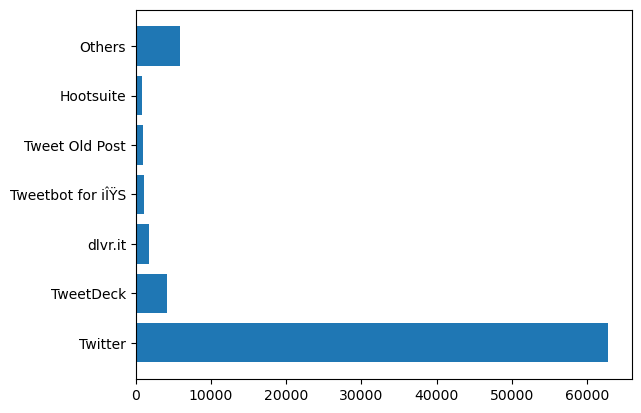

In [583]:
gg.createApplicationChart(df)
plt.show()
plt.clf()

C:\Users\msmai\OneDrive\桌面\St Andrews\CS2006\Python\CS2006P\notebooks\../code\generateGraphs.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for index, j in enumerate(df['Hashtags']):


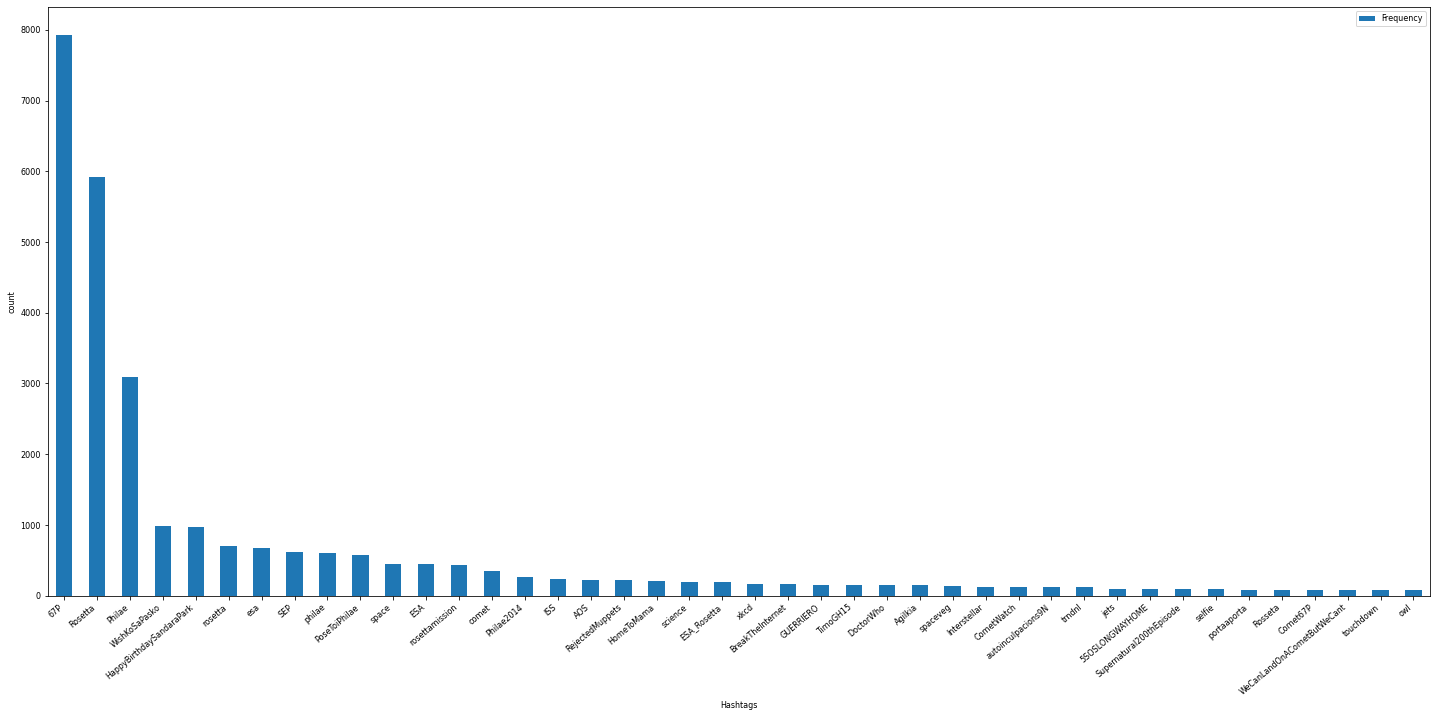

<Figure size 360x360 with 0 Axes>

In [8]:
gg.createHashtagChart("../data/CometLandingFixed.json")
plt.show()
plt.clf()

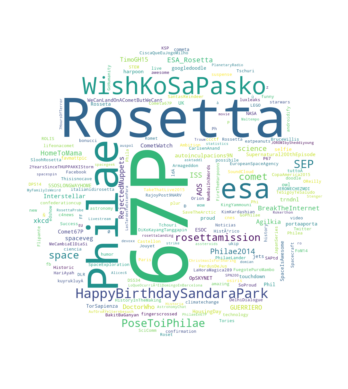

<Figure size 640x480 with 0 Axes>

In [ ]:
gg.createWordCloud(gg.getListOfAllHashTags("../data/CometLandingFixed.json"))
plt.show()
plt.clf()

For the analysis of the most popular hashtags used, we decided to exclude "CometLanding" of any case as all tweets in the dataset should have this hashtag which will automatically make it the most popular hashtag.  As shown in the bar chart and the word cloud, the top 3 most popular hastags are "67P", "Rosetta" and "Philae".  The reason of popularity is likely due to the name of comet being 67P, Rosetta being the name of space probe orbitting around the comet for observation and Philae being the name of the lander module of Rosetta that landed on the comet.

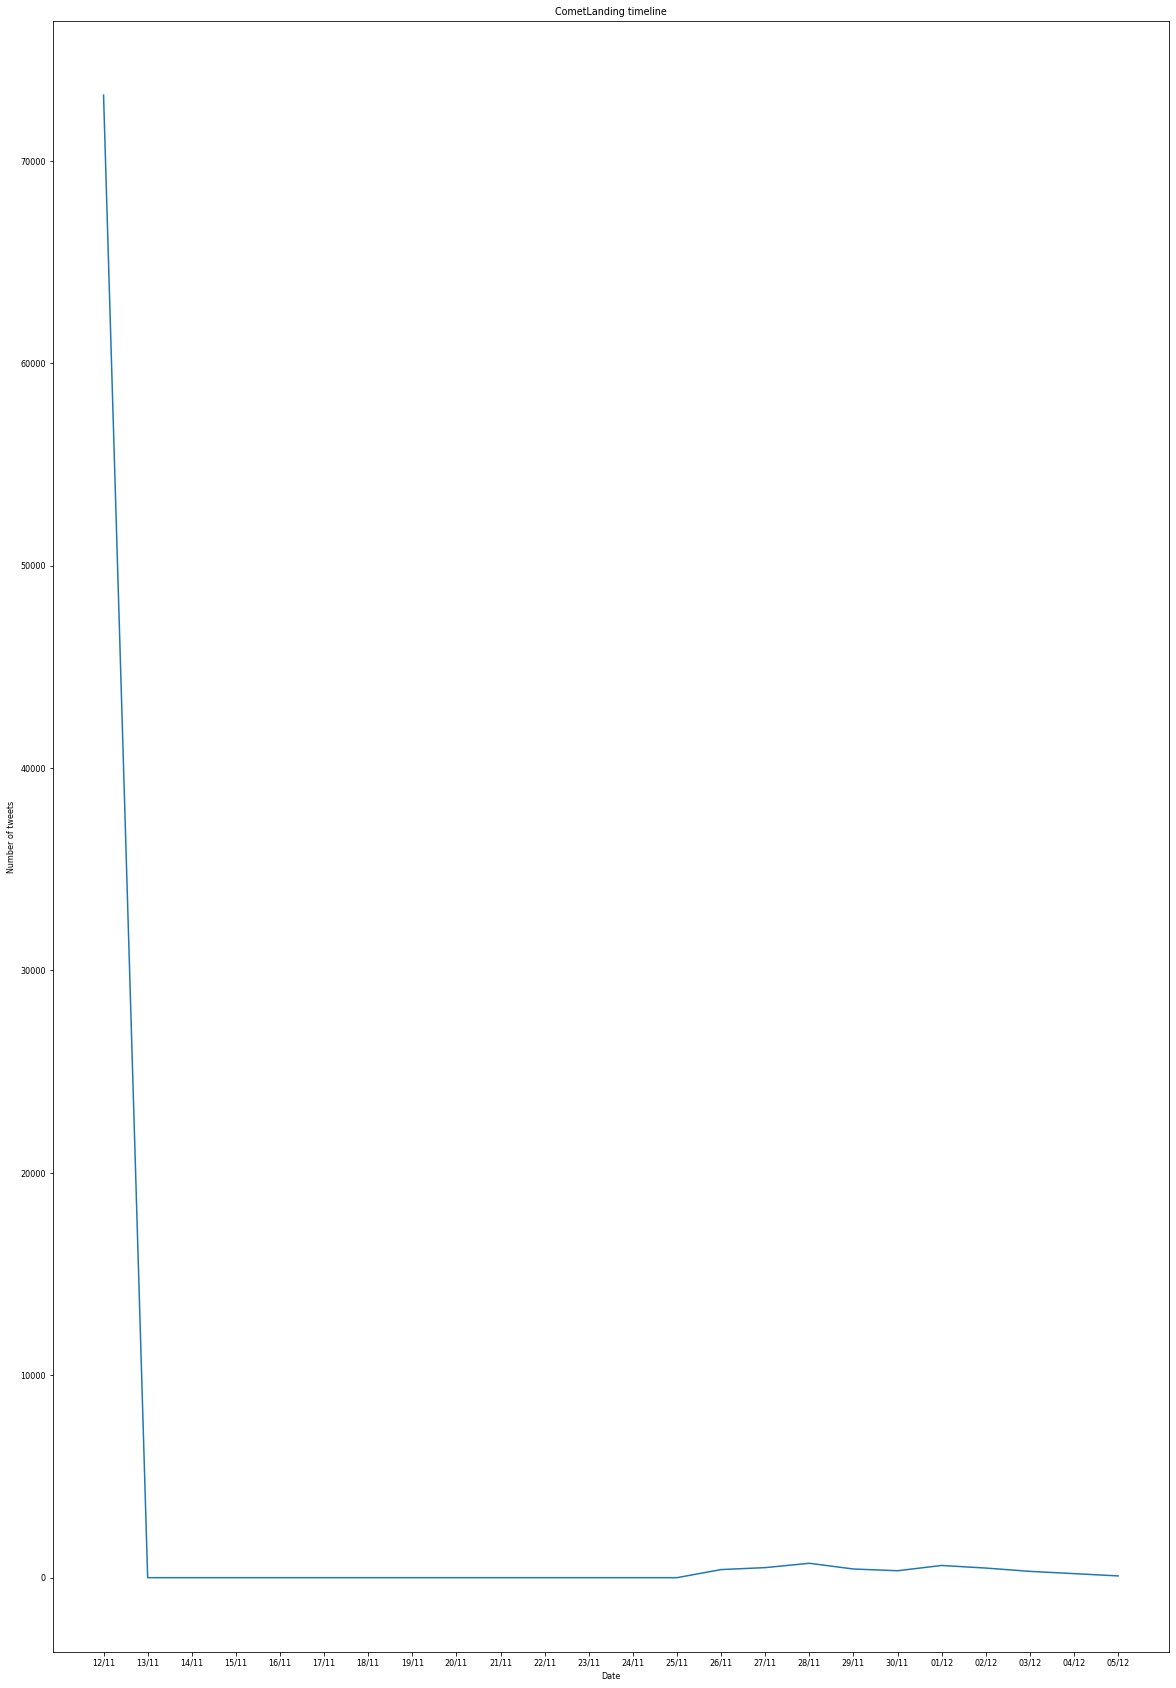

<Figure size 1440x2160 with 0 Axes>

In [21]:
gg.createDailyTimelinePlot(df)
# plt.savefig("Test.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

As observed from the timeline plot for each day during the observation period, the tweets are mainly sent on 12-11-2014, and after that day tweeting activity with the hashtag "CometLanding" is extremely low.  The reason of 12-11-2014 being the most active day is likely to be that the lander Philae was landed on the comet 67P on this day.  The low tweeting activity level beyond 12-11-2014 suggests that the popularity of this landing event does not last beyong the day of landing, that in the end the landing is not a topic of great concern for the general public.

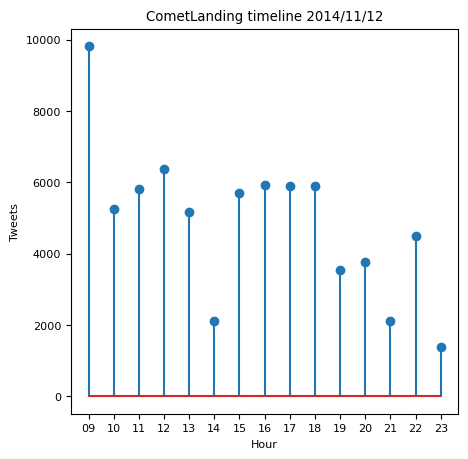

<Figure size 500x500 with 0 Axes>

In [582]:
gg.createActiveDayTimelinePlot(df)
plt.show()
plt.clf()

An additional graph is plotted to show the tweets timeline specifically on 12-11-2014, which is the day of comet landing and the date with most tweets sent with the hashtag "CometLanding" during the observation period.  Tweets started to be sent during 09:00 - 09:59 UTC, where this time period also has the most active tweeting activity.  Both observations may be explained by the fact that the lander Philae detached from the space probe at 08:35 UTC on the same day, where 09:00 - 09:59 UTC was around the time of the beginning of the landing process.

In [34]:
%matplotlib inline

In [32]:
day = df.set_index('created_at').groupby(pd.Grouper(freq='D'))

In [33]:
%matplotlib
#data
date_list_raw = [str(ts.strftime("%Y-%m-%d"))for ts in day.count()["id_str"].index.tolist()]
date_list = [] # Dates with tweets
date_data_list = []
date_label_list = []

for d in date_list_raw:
    date_raw = df[df['created_at'].apply(lambda x: True if re.search('^'+d, str(x)) else False)]
    date = date_raw.set_index('created_at').groupby(pd.Grouper(freq='H'))
    date_labels = [str(ts.strftime("%H"))for ts in date.count()["id_str"].index.tolist()]
    date_data = date.count()["id_str"].tolist()
    
    if(len(date_data) > 0 ):
        date_list.append(d) # append dates that contains tweets
        date_data_list.append(date_data)
        date_label_list.append(date_labels)



#graph
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
l, = plt.plot(date_label_list[0], date_data_list[0], lw=2)

class Index:
    
    def __init__(self):
        self.i = 0
        self.draw_graph()

    def next(self, event):
        self.i = (self.i + 1) % len(date_list)
        self.draw_graph()
  
        
            
    def prev(self, event):
        self.i -= 1
        if(self.i == -1): 
            self.i= len(date_list)-1
        self.draw_graph()
    
    def draw_graph(self):
        
        plt.clf()
        plt.title("CometLanding timeline " + date_list[self.i])
        plt.xlabel("Hour")
        plt.ylabel("Tweets")
        plt.plot(date_label_list[self.i], date_data_list[self.i])
        plt.draw()
        
        
       
        axprev = plt.axes([0.7, 0.05, 0.1, 0.075])  #Button position
        axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) #Button position
        self.bnext = Button(axnext, 'Next') 
        self.bnext.on_clicked(self.next)
        self.bprev = Button(axprev, 'Previous')
        self.bprev.on_clicked(self.prev)
        
        
        

Index()
plt.show()

Using matplotlib backend: Qt5Agg
